Author: Rohan Krishna Balaji  <br>
Course : Simulation Science <br>
Date  : 25.06.2021  <br>
Project : ICTM Analysis, Master's Thesis at Fraunhofer IPT <br>
Email :  rohan.balaji@rwth-aachen.de <br>
Verion : 1.01 <br>

# Introduction
To obtain the complete data set which includes feature from both planning data used in CAM planning and machining data obtained from Parquet fles First is to convert the machining data in machine coordinate system to tool tip data in work space coordinate system through 'Forward Kinematic Transformations' on compensated data. Then each tool tip data is clusterd to the correspoding acqired data points. Then the obtained clasters are averged to generate combined dataset with both planning and machining data.
The dataset is filtered to remove the outliers

In [1]:
# Importing necessary libraries and general settings
import transformation
import compensation
import data_imports
import pandas as pd
import os
import glob
import math
import re
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
from mpl_toolkits import mplot3d
import numpy as np
from scipy.signal import find_peaks

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
np.set_printoptions(threshold=np.inf)

Path locations (folder location) for respective files

In [2]:
dir_paraquet = 'Manufacturing_Data/'
dir_planning = 'Planing_Data/'
dir_final_save  = 'Final_df/' 

In [3]:
print('Enter the Block number, example 1030')
block = input()
block = int(block)

Enter the Block number, example 1030
1030


In [4]:
## print('Enter the blade angle, muliples of 12')
angle = input()
angle = int(angle)

24


In [ ]:
# Importing all the data
df_m,df_p,compensation_values_df = data_imports.data_out(block,angle,dir_paraquet,dir_planning)

In [ ]:
df_p.columns

In [ ]:
df_m.columns

In [ ]:
# Just copying machine data points linear(x,y,x) and rotart (a,c) into arrays.
# These machine points (x,y,x,a,c) are transformed from machine coordinate system to workpiece coordinate system by forward tramsformation

x = df_m['MachineX'].copy(deep=True)
y = df_m['MachineY'].copy(deep=True)
z = df_m['MachineZ'].copy(deep=True)
a = np.radians(df_m['MachineA']).copy(deep=True)
c = np.radians(df_m['MachineC']).copy(deep=True)

size1 = x.shape[0]

# converting pandas series to numpy array
x = x.to_numpy()
y = y.to_numpy()
z = z.to_numpy()
a = a.to_numpy()
c = c.to_numpy()

In [ ]:
#compensation_values
compensation_values = compensation_values_df.to_numpy()

### Applying compensation on the Aquired Data
Based on the macine position compensation is applied to the machine datat, so that the errors are negated. This is implemented in the script compensation.py 
<img src="images/compensation.png">

In [ ]:
# Within each cube we have ranges defined in x,y,z for the machine position

x_range = np.arange(-200,201,100)
y_range = np.arange(-300,301,150)
z_range = np.arange(-500,1,50)

obj3 = compensation.Compensation(compensation_values,x_range,y_range,z_range)

# Caclculation of compensation error values based on machine positions obtained through inverse transformation
deltaX1, deltaY1, deltaZ1,deltaI1,deltaJ1,deltaK1 = obj3.calculate(x,y,z)  
size3 = x.shape[0]

conc3 = np.concatenate((deltaX1.reshape(size3,1),deltaY1.reshape(size3,1),deltaZ1.reshape(size3,1),deltaI1.reshape(size3,1),deltaJ1.reshape(size3,1),deltaK1.reshape(size3,1)),axis=1)

# prininting the compensation error values
df_obj3 = pd.DataFrame(conc3, columns=['deltaX1','deltaY1','deltaZ1','deltaI1','deltaJ1','deltaK1'])
df_obj3.head(5)  
                          

In [ ]:
x_compensated = x + deltaX1*10**-3    # since given compensation is to be converted from microns to mm (10**-6 x 10**3 = 10**-3)
y_compensated = y + deltaY1*10**-3
z_compensated = z + deltaZ1*10**-3

conc4 = np.concatenate((x_compensated.reshape(size3,1),y_compensated.reshape(size3,1),z_compensated.reshape(size3,1)),axis=1)
df_obj4 = pd.DataFrame(conc4, columns=['x_compensated','y_compensated','z_compensated'])
df_obj4.head(5)

In [ ]:
df_m['compensation_x'] = deltaX1*10**-3
df_m['compensation_y'] = deltaY1*10**-3
df_m['compensation_z'] = deltaZ1*10**-3
df_m.iloc[10000:10010]

### Forward Transformation:
Forward transformation is performed by applying rotational and transitional
transformations on the machine points and orientation in the machine coordi-
nate system.
There are two ways to interpret the transformations. Firstly, by pre-multiplication
of all the transformation matrices with respect to base coordinate system (i.e
Machine Coordinate System). Second method is the apply post- multiplica-
tion this can be understood as applying 'Relative Transformation'.
The notation used for machine data points obtained by paraqet fles are
x,y,z,a,c in machine coordinate system. The tool tip and orientations obtained
in workpiece coordinate system X,Y,Z,I,J,K. This is implemented in transformation.py script.

<img src="images/transformation.png">

In [ ]:
obj = transformation.Transformation(size1,angle)
# Forward Transformation fuction:
# Input : Machine points in machine coordinate system
# Output: returns too tip points and orientation in workpiece coordinate system
tool_position_workpiece_CS, tool_orientation_workpiece_CS = obj.forward(x_compensated,y_compensated,z_compensated,a,c)

X = tool_position_workpiece_CS[0,0,:]
Y = tool_position_workpiece_CS[1,0,:]
Z = tool_position_workpiece_CS[2,0,:]
print(X.shape)

I = tool_orientation_workpiece_CS[0,0,:]
J = tool_orientation_workpiece_CS[1,0,:]
K = tool_orientation_workpiece_CS[2,0,:]

# Verification the correctness of code, i.e on applying reverse transformation on the forward transformation we should get same values or equivalent values i.e (cos(a or c),sin(a or c))
machine_points_xyz, machine_direction_ac = obj.backward(X,Y,Z,I,J,K)

x_out = machine_points_xyz[0,0,:]
y_out = machine_points_xyz[1,0,:]
z_out = machine_points_xyz[2,0,:]

a_out = machine_direction_ac[0,0,:]
c_out = machine_direction_ac[1,0,:]

conc1 = np.concatenate((x.reshape(size1,1),x_out.reshape(size1,1),y.reshape(size1,1),y_out.reshape(size1,1),z.reshape(size1,1),z_out.reshape(size1,1),a.reshape(size1,1),a_out.reshape(size1,1),c.reshape(size1,1),c_out.reshape(size1,1)),axis=1)

df_obj1 = pd.DataFrame(conc1, columns=['x','x_out','y','y_out','z','z_out','a','a_out','c','c_out'])

df_obj1.iloc[10000:10005]


In [ ]:
conc11 = np.concatenate((x.reshape(size1,1),y.reshape(size1,1),z.reshape(size1,1),a.reshape(size1,1),c.reshape(size1,1),X.reshape(size1,1),Y.reshape(size1,1),Z.reshape(size1,1),I.reshape(size1,1),J.reshape(size1,1),K.reshape(size1,1)),axis=1)
dfout11 = pd.DataFrame(conc11, columns=['x','y','z','a','c','X','Y','Z','I','J','K'])
dfout11.head(10)


In [ ]:
# example
n = 15000
distance1 = (((df_p['Tool Tip Point X']-X[n])**2+(df_p['Tool Tip Point Y']-Y[n])**2+(df_p['Tool Tip Point Z']-Z[n])**2)**(1/2))
distance1.min()

In [ ]:
tool_tip_X = df_p['Tool Tip Point X'].to_numpy()
tool_tip_Y = df_p['Tool Tip Point Y'].to_numpy()
tool_tip_Z = df_p['Tool Tip Point Z'].to_numpy()
leading_angle = df_p['Leading angle'].to_numpy()
side_tilt_angle = df_p['Side tilt angle'].to_numpy()
tool_orientation_X = df_p['Tool Orientation X'].to_numpy()
tool_orientation_Y = df_p['Tool Orientation Y'].to_numpy()
tool_orientation_Z = df_p['Tool Orientation Z'].to_numpy()

I = tool_orientation_X
J = tool_orientation_Y
K = tool_orientation_Z

X_inv=tool_tip_X
Y_inv=tool_tip_Y
Z_inv=tool_tip_Z

In [5]:
# Plotting the result obtained during the study
def subplotter(low,high,X,Y,Z,X_inv,Y_inv,Z_inv):
    
    range = np.arange(low,high)
    fig,axs = plt.subplots(3,figsize=(10,15))

    axs[0].plot(range,X[range],label = 'X acquired', color='blue')
    axs[0].plot(range,X_inv[range],label = 'X planning', color='red')
    axs[0].legend() 
    axs[0].set_xlabel('row index (dimension less)')
    axs[0].set_ylabel('X in mm')
    #axs[0].set_title('X data comparison')   
    
    axs[1].plot(range,Y[range], label = 'Y acquired', color='blue')
    axs[1].plot(range,Y_inv[range], label = 'Y planning', color='red') 
    axs[1].legend()
    axs[1].set_xlabel('row index (dimension less)')
    axs[1].set_ylabel('Y in mm')
   # axs[1].set_title('Y data comparison')   
    

    axs[2].plot(range,Z[range], label = 'Z acquired', color='blue')
    axs[2].plot(range,Z_inv[range] , label = 'Z planning', color='red')
    axs[2].legend()
    axs[2].set_xlabel('row index (dimension less)')
    axs[2].set_ylabel('Z in mm')
    #axs[2].set_title('Z data comparison')   
    
    
    fig.canvas.draw()
    fig.canvas.flush_events()


### Findingt the closest points
Here the distances are calculated, for each aquired data point, forward transformation was performed above, and now for each of those poits the disace for all planning points are calculated. Partition the data into 5 chuncks and find the closest distance points in those chucks, if we use full set at once, we may match up with far way points, which were causing lots of outliers.the position closest the iterator is considered, since the far away values are thus avoided from matching. store both position and the value in two separate lists

In [ ]:
# Here the distances are calculated, for each aquired data point, forward transformation was performed above,
# and now for each of those poits the disace for all planning points are calculated.
lst1 = []
lst2 = []

dist  = np.zeros(len(tool_tip_X))
print('Enter the tolerance number value, example 3 mm')
tol = input()

count = 0 
k = 5

for i in np.arange(len(X)):   # 47917
    
    dist = (((tool_tip_X-X[i])**2+(tool_tip_Y-Y[i])**2+(tool_tip_Z-Z[i])**2)**(1/2))
    
    # partition the data into 5 chuncks and find the closest distance points in those chucks, if we use full set at once, 
    # we may match up with far way points, which were causing lots of outliers
    
    pos = np.argpartition(dist, k)
    pos = pos[:k]
    min_val = dist[pos]
    #print(pos,min_val)
    
    # the position closest the iterator is considered, since the far away values are thus avoided from matching
    pos = pos[np.argmin(abs(pos - i))]
    min_val = dist[pos]
    
    #print(i,pos,min_val)
    # store both position and the value in two separate lists
    if(abs(min_val<=float(tol))): 
        lst1.append(pos)
        lst2.append(min_val)
        count = count+1
        print(i,pos,min_val,count)
    else:
        lst1.append(np.nan)
        lst2.append(np.nan)
   

In [ ]:
print(np.shape(lst1))

In [ ]:
# Seeing all the unique clusers and number of points in it (Just for understanding)
(unique,count) = np.unique(lst1, return_counts=True)

df_freq = pd.DataFrame({'Unique Cluster Points':np.array(unique),'Count':np.array(count)})
df_freq = df_freq.dropna()
df_freq.iloc[:]

In [ ]:
df_cluster = pd.DataFrame({'cluster index in planning data':np.array(lst1),'distance error':np.array(lst2)})
#df_cluster = df_cluster.dropna()
df_cluster.iloc[22000:22100]

### Clustering:
For a given planning point, there are none or multiple matching acquried points, those are found in this section. For each planning datapoint, see whih index match with the stored index for minimum distance. Those can be considered as the cluster points and the corresponding distance. 

<img src="images/cluster.png">

In [ ]:
# Clustering: for a given planning point, there are none or multiple matching acquried points, those are found in this section of code 
lst3 = []
tcp_val = []
# For each planning datapoint, see whih index match with the stored index for minimum distance.
# Those can be considered as the cluster points and the corresponding distance
for i in np.arange(len(tool_tip_Y)):     # each planning point
    
    matching = np.where(np.array(lst1)==i)    # see what all machine points matches
    tcp_val.append([lst2[index] for index in matching[0]])          # get the same minmum tcp error distance 
    lst3.append(matching[0])
    print(i,matching[0])
    

### Visualization

In [ ]:
# list for plotting
pltlst = []
for i in np.arange(len(tool_tip_X)):
    if (len(lst3[i]) != 0):
        pltlst.append(i)
        #print(i,lst3[i])

In [ ]:
# Plot to show clusters
tool_tip_X_2, tool_tip_Y_2, tool_tip_Z_2, leading_angle_2, side_tilt_angle_2,tool_orientation_X2,  tool_orientation_Y2,tool_orientation_Z2 = np.zeros(len(pltlst),),np.zeros(len(pltlst),),np.zeros(len(pltlst),),np.zeros(len(pltlst),),np.zeros(len(pltlst),),np.zeros(len(pltlst),),np.zeros(len(pltlst),),np.zeros(len(pltlst),)

plt.figure(figsize=(10,15))
ax = plt.axes(projection='3d')
ax.set_zlim3d([0,30])
ax.set_xlabel('$X$ in mm', fontsize=20)
ax.set_ylabel('$Y$ in mm', fontsize=20)
ax.set_zlabel('$Z$ in mm', fontsize=20)

# Planning Data
for i in np.arange(len(pltlst)):
    tool_tip_X_2[i] = tool_tip_X[pltlst[i]]
    tool_tip_Y_2[i] = tool_tip_Y[pltlst[i]]
    tool_tip_Z_2[i] = tool_tip_Z[pltlst[i]]
    leading_angle_2[i] = leading_angle[pltlst[i]]
    side_tilt_angle_2[i] =  side_tilt_angle[pltlst[i]]
    tool_orientation_X2[i] = tool_orientation_X[pltlst[i]]
    tool_orientation_Y2[i] = tool_orientation_Y[pltlst[i]]
    tool_orientation_Z2[i] = tool_orientation_Z[pltlst[i]]

ax.scatter3D(tool_tip_X_2,tool_tip_Y_2,tool_tip_Z_2, color = 'red',label = 'Planning Data')
ax.legend()

X_2,Y_2,Z_2, x_2,y_2,z_2,a_2,c_2 = np.zeros(len(pltlst),),np.zeros(len(pltlst),),np.zeros(len(pltlst),),np.zeros(len(pltlst),),np.zeros(len(pltlst),),np.zeros(len(pltlst),),np.zeros(len(pltlst),),np.zeros(len(pltlst),)

# Transformed Aquired data
for i in np.arange(len(pltlst)):
    X_2[i] = np.average(X[tuple([lst3[pltlst[i]]])])
    Y_2[i] = np.average(Y[tuple([lst3[pltlst[i]]])])
    Z_2[i] = np.average(Z[tuple([lst3[pltlst[i]]])])
    
    x_2[i] = np.average(x[tuple([lst3[pltlst[i]]])]) 
    y_2[i] = np.average(y[tuple([lst3[pltlst[i]]])]) 
    z_2[i] = np.average(z[tuple([lst3[pltlst[i]]])]) 
    a_2[i] = np.average(a[tuple([lst3[pltlst[i]]])]) 
    c_2[i] = np.average(c[tuple([lst3[pltlst[i]]])])
ax.scatter3D(X_2,Y_2,Z_2, color = 'blue',label = 'Machine Data Avg')
ax.legend()

In [ ]:
final_dictionary = {'Tool Tip Point X':tool_tip_X_2, 'Tool Tip Point Y':tool_tip_Y_2, 'Tool Tip Point Z':tool_tip_Z_2,
                    'Tool Orientation X':tool_orientation_X2, 'Tool Orientation Y':tool_orientation_Y2, 'Tool Orientation Z':tool_orientation_Z2,
                    'Leading angle': leading_angle_2, 'Side tilt angle':side_tilt_angle_2,
                    
                    'MachineX':x_2, 'MachineY':y_2, 'MachineZ':z_2, 'MachineA':a_2, 'MachineC':c_2,
                    'X':X_2 , 'Y':Y_2, 'Z':Z_2
                   }
final_df = pd.DataFrame(final_dictionary)

In [ ]:
final_df.iloc[0:100]

In [ ]:
final_df.to_excel(str(dir_final_save)+'final_df_'+str(block)+'__'+str(angle)+'.xlsx') 

In [6]:
final_df = pd.read_excel(str(dir_final_save)+'final_df_'+str(block)+'__'+str(angle)+'.xlsx') 

In [7]:
final_df.columns

Index(['Unnamed: 0', 'Tool Tip Point X', 'Tool Tip Point Y',
       'Tool Tip Point Z', 'Tool Orientation X', 'Tool Orientation Y',
       'Tool Orientation Z', 'Leading angle', 'Side tilt angle', 'MachineX',
       'MachineY', 'MachineZ', 'MachineA', 'MachineC', 'X', 'Y', 'Z'],
      dtype='object')

In [44]:
x = final_df['MachineX'].copy(deep=True) 
y = final_df['MachineY'].copy(deep=True) 
z = final_df['MachineZ'].copy(deep=True) 
a = final_df['MachineA'].copy(deep=True) 
c = final_df['MachineC'].copy(deep=True) 

X_inv = final_df['Tool Tip Point X'].copy(deep=True) 
Y_inv = final_df['Tool Tip Point Y'].copy(deep=True) 
Z_inv = final_df['Tool Tip Point Z'].copy(deep=True) 
size1 = x.shape[0]

In [45]:
obj = transformation.Transformation(size1,angle)
# Forward Transformation fuction:
# Input : Machine points in machine coordinate system
# Output: returns too tip points and orientation in workpiece coordinate system
tool_position_workpiece_CS, tool_orientation_workpiece_CS = obj.forward(x,y,z,a,c)

X = tool_position_workpiece_CS[0,0,:]
Y = tool_position_workpiece_CS[1,0,:]
Z = tool_position_workpiece_CS[2,0,:]
print(X.shape)

(21771,)


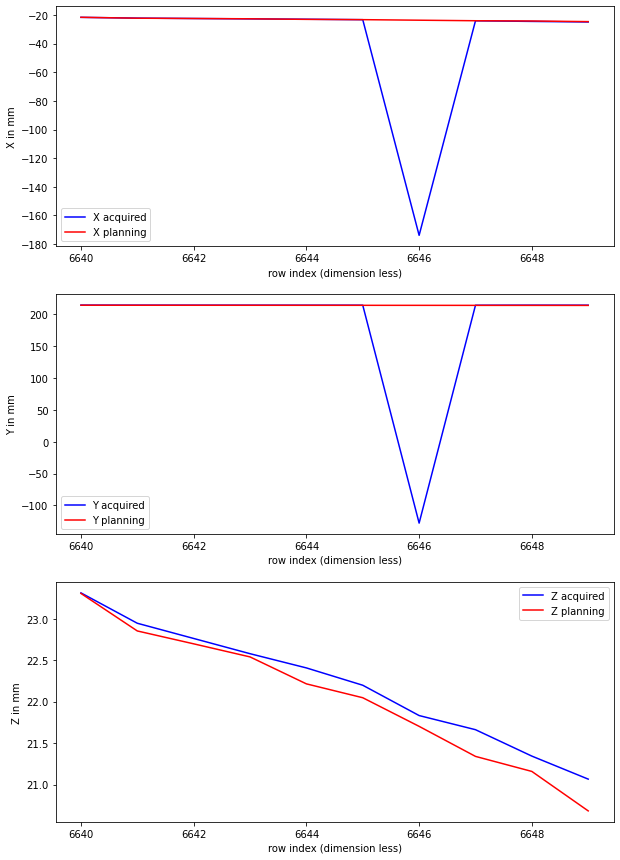

In [46]:
subplotter(6640,6650,X,Y,Z,X_inv,Y_inv,Z_inv)

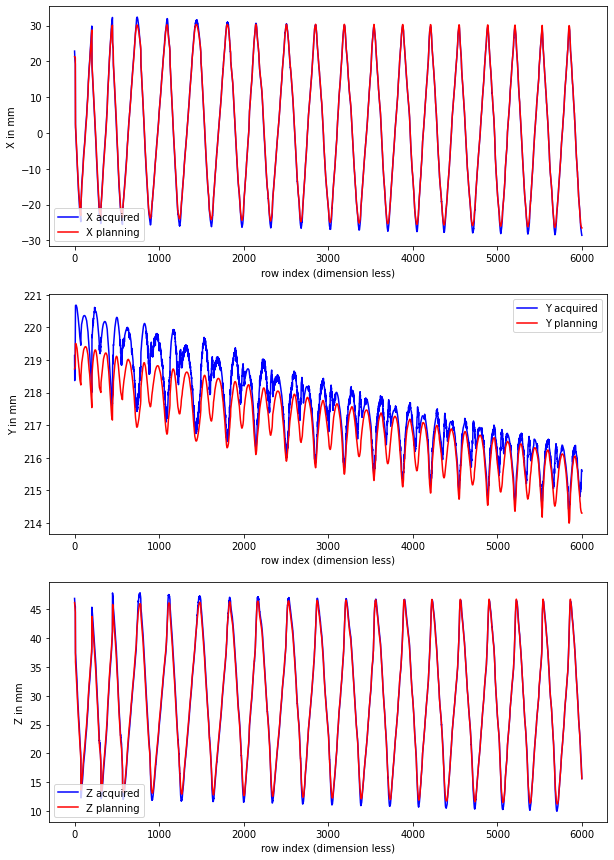

In [47]:
subplotter(0,6000,X,Y,Z,X_inv,Y_inv,Z_inv)

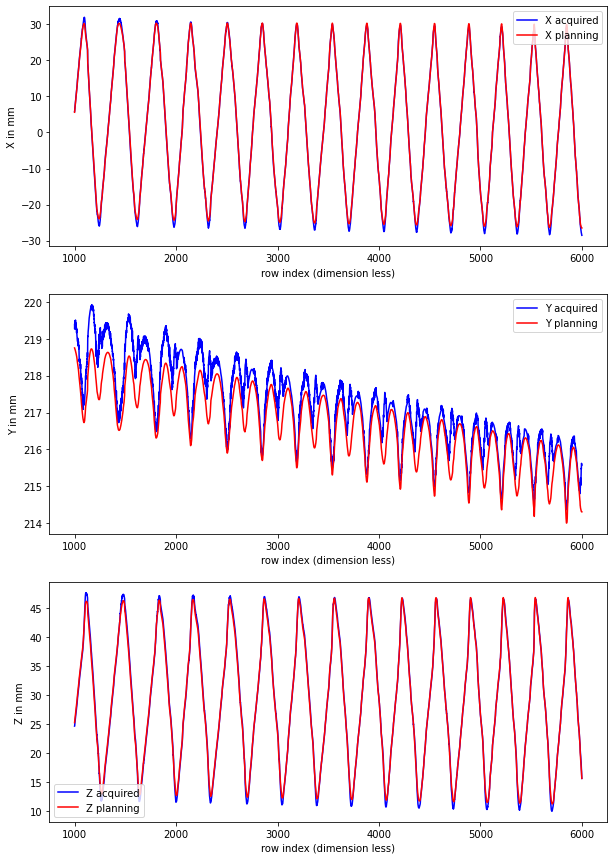

In [48]:
subplotter(1000,6000,final_df['X'],final_df['Y'],final_df['Z'],X_inv,Y_inv,Z_inv)

In [49]:
final_df.iloc[6646]

Unnamed: 0            6646.000000
Tool Tip Point X       -23.615776
Tool Tip Point Y       214.224655
Tool Tip Point Z        21.701950
Tool Orientation X      -0.026437
Tool Orientation Y       0.999637
Tool Orientation Z       0.005178
Leading angle           -0.265443
Side tilt angle          1.333889
MachineX              -108.936367
MachineY               -53.613167
MachineZ              -163.353600
MachineA                -1.280538
MachineC                 2.094453
X                      -23.751422
Y                      214.456308
Z                       21.841550
Name: 6646, dtype: float64

In [50]:
final_df.iloc[6640:6650]

,Unnamed: 0,Tool Tip Point X,Tool Tip Point Y,Tool Tip Point Z,Tool Orientation X,Tool Orientation Y,Tool Orientation Z,Leading angle,Side tilt angle,MachineX,MachineY,MachineZ,MachineA,MachineC,X,Y,Z
6640,6640,-21.588610,214.429886,23.305218,-0.025765,0.999651,0.005917,-0.579729,1.477757,-107.391200,-54.005200,-161.9580,-1.276776,6.281351,-21.608080,214.600718,23.321109
6641,6641,-22.218626,214.367981,22.852570,-0.026015,0.999645,0.005698,-0.497476,1.454022,-107.722600,-53.884100,-162.2865,-1.277607,6.282079,-22.142566,214.550598,22.954789
6642,6642,-22.425413,214.347290,22.697245,-0.026090,0.999644,0.005625,-0.447836,1.439020,-107.890000,-53.829300,-162.4534,-1.278051,6.282433,-22.409782,214.525070,22.771297
6643,6643,-22.630354,214.326599,22.539463,-0.026160,0.999642,0.005551,-0.402037,1.420341,-108.058400,-53.778400,-162.6219,-1.278513,6.282779,-22.676279,214.499414,22.587601
6644,6644,-23.032871,214.285446,22.214455,-0.026285,0.999640,0.005403,-0.336622,1.387087,-108.216800,-53.735300,-162.7811,-1.278965,6.283093,-22.924707,214.475146,22.416115
6645,6645,-23.230255,214.265015,22.047190,-0.026340,0.999639,0.005328,-0.307500,1.368182,-108.413000,-53.687300,-162.9778,-1.279536,0.000271,-23.226815,214.445480,22.207135
6646,6646,-23.615776,214.224655,21.701950,-0.026437,0.999637,0.005178,-0.265443,1.333889,-108.936367,-53.613167,-163.3536,-1.280538,2.094453,-23.751422,214.456308,21.841550
6647,6647,-23.992144,214.184677,21.339649,-0.026515,0.999636,0.005026,-0.233156,1.300397,-108.928100,-53.589200,-163.4959,-1.281112,0.001124,-23.999241,214.367449,21.671066
6648,6648,-24.170109,214.165573,21.158264,-0.026545,0.999635,0.004951,-0.216075,1.283883,-109.762950,-53.547100,-163.8895,-1.282004,6.282333,-24.446265,214.511743,21.352526
6649,6649,-24.605961,214.118271,20.682249,-0.026608,0.999635,0.004722,-0.191741,1.244656,-110.039200,-53.525600,-164.1717,-1.282955,6.282702,-24.842466,214.470115,21.074861


In [52]:
X[6644:6648]

array([ -22.94029561,  -23.2424036 , -173.86814044,  -24.01482921])

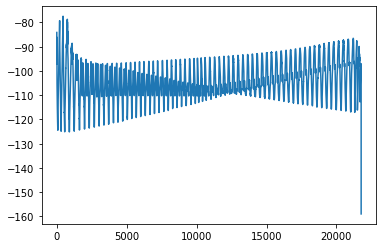

In [18]:
plt.plot(x)

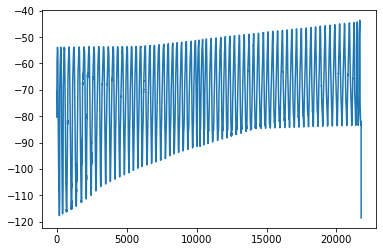

In [20]:
plt.plot(y)

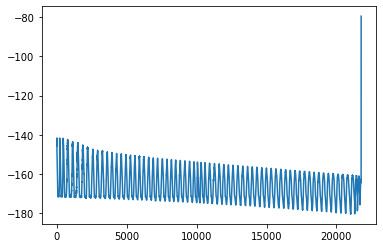

In [21]:
plt.plot(z)

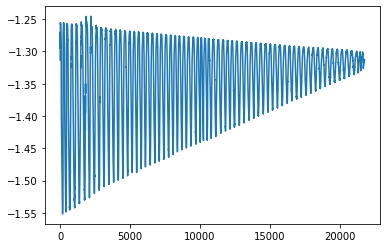

In [22]:
plt.plot(a)

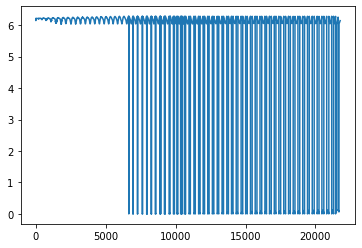

In [23]:
plt.plot(c)

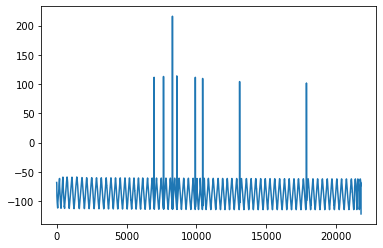

In [29]:
plt.plot(X)

In [67]:
import math
import re
import numpy as np
#  Vocabulary

# Opr : Program origin (G54)
# Om : Machine origin (unknow point somewhere out of work space)
# Ot : Turret origin (liaison with the öachine)
# Ob : Rotation center of B 
# Tcp : Tool center point 


#  Program origin  (G54 values) 
OprOm_x = 0
OprOm_y = 0
OprOm_z = -510.4830#+167.85

#  Tool position 
OmOt_x = x  
OmOt_y = y
OmOt_z = z
OmOt_a = np.radians(a)
OmOt_c = np.radians(c)

#  Zeropoint to A Table
OtOa_x =0.006
OtOa_y =-0.0083  
OtOa_z =-600.2366

#  C excentration from Table
OtOc_x = 0.000
OtOc_y = -0.0039
OtOc_z = -79.7629

l = 0
tl = 226.4591
#  Tool dimensions 
T_x = 0
T_y = 0
T_z = tl-l
T_CentertoTip = l

# Translation Werkzeuglänge und Base Tool   -> Reihenfolgen der Translationen und Rotationen zu hinterfragen
nx = OmOt_x-OtOa_x-T_x
ny = OmOt_y-OtOa_y-T_y
nz = OmOt_z-OtOa_z-T_z 
na = OmOt_a   # these are unkown
nc = OmOt_c

#ROT um X --> A-Achse
OmOt_x = nx
OmOt_y = np.cos(na)*ny - np.sin(na)*nz
OmOt_z = np.sin(na)*ny + np.cos(na)*nz

#JO Translation
nx = OmOt_x - OtOc_x
ny = OmOt_y - OtOc_y
nz = OmOt_z - OtOc_z

# rot z -> C-Achse
OmOt_x =  np.cos(nc)*nx - np.sin(nc)*ny
OmOt_y =  np.sin(nc)*nx + np.cos(nc)*ny
OmOt_z =  nz

#G54 Transformationen und Werkzeuglänge zurück transformieren -> Ab hier wahrscheinlich kein fehler mehr! <<-- DOCH!!
X = OmOt_x - OprOm_x + OtOa_x +OtOc_x
Y = OmOt_y - OprOm_y + OtOa_y + OtOc_y
Z = OmOt_z - OprOm_z + OtOa_z + OtOc_z 


In [62]:
X[6644:6648]

6644   -102.204105
6645   -108.412769
6646   -107.076986
6647   -108.927141
dtype: float64

In [64]:
Y[6644:6648]

6644   -60.562094
6645   -48.967216
6646   -52.846133
6647   -48.876519
dtype: float64

In [40]:
Y

6644    186.619280
6645    186.469283
6646   -187.507253
6647    186.083778
dtype: float64

In [55]:
Y[6644:6648]

array([ 214.49391203,  214.4642272 , -127.84115796,  214.38614553])

In [41]:
Z

6644    22.406793
6645    22.197806
6646    21.832209
6647    21.661718
dtype: float64

In [54]:
Z[6644:6648]

array([22.40679347, 22.19780561, 21.83220858, 21.66171798])

In [66]:
=

pandas.core.series.Series

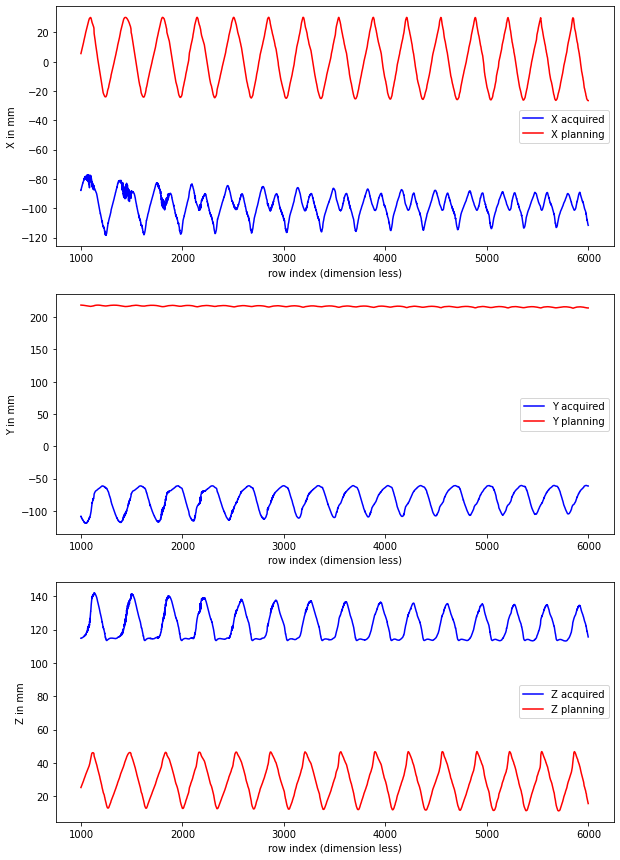

In [68]:
subplotter(1000,6000,X,Y,Z,X_inv,Y_inv,Z_inv)